# 760 HW5

## 1. Clustering

#### 1.2. K-means Clustering and GMM

In [174]:
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt

In [175]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [201]:
def k_means(data, k, max_iterations=100):
    best_centroids = None
    best_clusters = None
    best_cluster_labels = None
    lowest_objective = 1e9
    for rand_init in range(20):
        centroids = np.array(data[np.random.choice(len(data), k, replace=False)])
        for _ in range(max_iterations):
            clusters = [[] for _ in range(k)]
            cluster_labels = []
            for point in data:
                cluster_index = np.argmin([euclidean_distance(point, centroid) for centroid in centroids])
                cluster_labels.append(cluster_index)
                clusters[cluster_index].append(point)
            
            new_centroids = [np.mean(cluster, axis=0) if cluster else centroids[i] for i, cluster in enumerate(clusters)]
            
            if np.array_equal(centroids, new_centroids):
                obj = clustering_objective(centroids, clusters)
                if obj < lowest_objective:
                    lowest_objective = obj
                    best_centroids = centroids
                    best_clusters = clusters
                    best_cluster_labels = cluster_labels
            
            centroids = new_centroids
    
    return best_centroids, best_clusters, best_cluster_labels

In [202]:
def clustering_accuracy(true_labels, cluster_labels, true_means, cluster_centroids):
    k = len(true_means)
    maps = permutations(range(k))
    max_match = 1e6
    true_map = None
    for m in maps:
        match = 0
        for i in range(len(m)):
            match += (true_means[i] - cluster_centroids[m[i]])**2
        if np.linalg.norm(match) < max_match:
            max_match = np.linalg.norm(match)
            true_map = m
    
    acc = 0

    for i in range(len(cluster_labels)):
        if cluster_labels[i] == true_map[true_labels[i]]:
            acc += 1
    
    return acc/len(cluster_labels)

In [203]:
def clustering_objective(centroids, clusters):
    objective = 0.0
    for i, centroid in enumerate(centroids):
        cluster_points = np.array(clusters[i])
        if cluster_points.shape[0] > 0:
            squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            objective += np.sum(squared_distances)
    return objective

In [221]:
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components, max_iterations=100, tolerance=1e-4):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = np.ones(n_components) / n_components
        self.means = None
        self.covariances = None
        self.cluster_assignments = None
        self.clusters = [[] for _ in range(n_components)]

    def fit(self, data):
        n_samples, n_features = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.identity(n_features) for _ in range(self.n_components)]

        for _ in range(self.max_iterations):
            responsibilities = self.expectation(data)
            self.maximization(data, responsibilities)

        # Assign each data point to the cluster with the highest responsibility
        self.cluster_assignments = np.argmax(responsibilities, axis=1)
        for i in range(len(data)):
            self.clusters[self.cluster_assignments[i]].append(data[i])

    def expectation(self, data):
        responsibilities = np.zeros((len(data), self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(data, self.means[k], self.covariances[k])

        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        return responsibilities

    def maximization(self, data, responsibilities):
        N_k = np.sum(responsibilities, axis=0)
        self.weights = N_k / len(data)
        self.means = np.dot(responsibilities.T, data) / N_k[:, np.newaxis]

        for k in range(self.n_components):
            diff = data - self.means[k]
            self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / N_k[k]

In [222]:
def Pa(sigma):
    return np.random.multivariate_normal([-1, -1], sigma*np.array([[2, 0.5], [0.5, 1]]), 100)
def Pb(sigma):
    return np.random.multivariate_normal([1, -1], sigma*np.array([[1, -0.5], [-0.5, 2]]), 100)
def Pc(sigma):
    return np.random.multivariate_normal([0, 1], sigma*np.array([[1, 0], [0, 2]]), 100)

In [223]:
sigmas = [0.5, 1, 2, 4, 8]
km_accs = []
km_objs = []
gmm_accs = []
gmm_objs = []

for sigma in sigmas:
    data = np.concatenate((Pa(sigma), Pb(sigma), Pc(sigma)))

    true_labels = np.array([0] * 100 + [1] * 100 + [2] * 100)
    true_means = [[-1, -1], [1, -1], [0, 1]]

    k = 3
    centroids, clusters, cluster_labels = k_means(data, k)

    km_accuracy = clustering_accuracy(true_labels, cluster_labels, true_means, centroids)
    km_objective = clustering_objective(centroids, clusters)
    km_accs.append(km_accuracy)
    km_objs.append(km_objective)

    print("Sigma: ", sigma)
    print("k-Means Clustering Accuracy: ", km_accuracy)
    print("k-Means Clustering Objective: ", km_objective)
    print()

    gmm = GaussianMixtureModel(n_components=3)
    gmm.fit(data)

    gmm_accuracy = clustering_accuracy(true_labels, gmm.cluster_assignments, true_means, gmm.means)
    gmm_objective = clustering_objective(gmm.means, gmm.clusters)
    gmm_accs.append(gmm_accuracy)
    gmm_objs.append(gmm_objective)
    
    print("GMM Clustering Accuracy: ", gmm_accuracy)
    print("GMM Clustering Objective: ", gmm_objective)
    
    print('_'*100)

Sigma:  0.5
k-Means Clustering Accuracy:  0.7933333333333333
k-Means Clustering Objective:  293.8946826852105

GMM Clustering Accuracy:  0.64
GMM Clustering Objective:  534.5671341254524
____________________________________________________________________________________________________
Sigma:  1
k-Means Clustering Accuracy:  0.73
k-Means Clustering Objective:  562.9299752827701

GMM Clustering Accuracy:  0.6466666666666666
GMM Clustering Objective:  818.686292548984
____________________________________________________________________________________________________
Sigma:  2
k-Means Clustering Accuracy:  0.61
k-Means Clustering Objective:  876.9255966942835

GMM Clustering Accuracy:  0.51
GMM Clustering Objective:  1371.0777878625358
____________________________________________________________________________________________________
Sigma:  4
k-Means Clustering Accuracy:  0.57
k-Means Clustering Objective:  1590.0618617657155

GMM Clustering Accuracy:  0.45666666666666667
GMM Clusteri

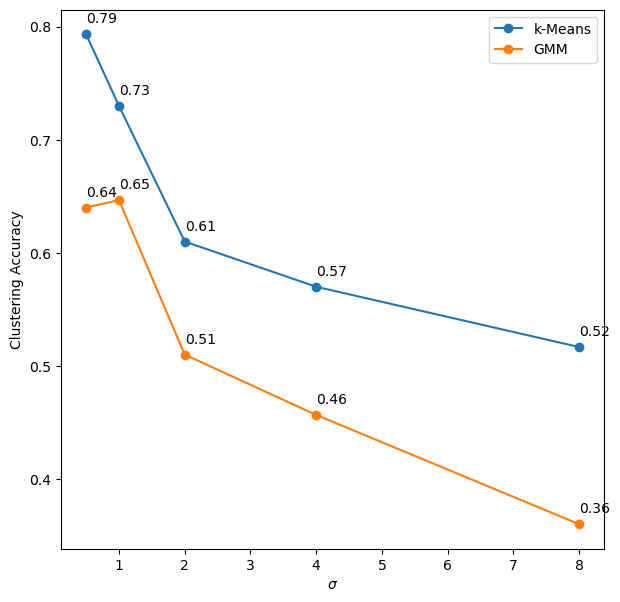

In [285]:
plt.figure(figsize=(7,7))
plt.plot(sigmas, km_accs, label="k-Means", marker='o')
plt.plot(sigmas, gmm_accs, label="GMM", marker='o')
for i in range(len(sigmas)):
    plt.annotate('{0:.2f}'.format(km_accs[i]), xy=(sigmas[i], km_accs[i]+0.01))
    plt.annotate('{0:.2f}'.format(gmm_accs[i]), xy=(sigmas[i], gmm_accs[i]+0.01))
plt.xlabel("$\sigma$")
plt.ylabel("Clustering Accuracy")
plt.legend()
plt.savefig("clustering_accuracy.pdf")

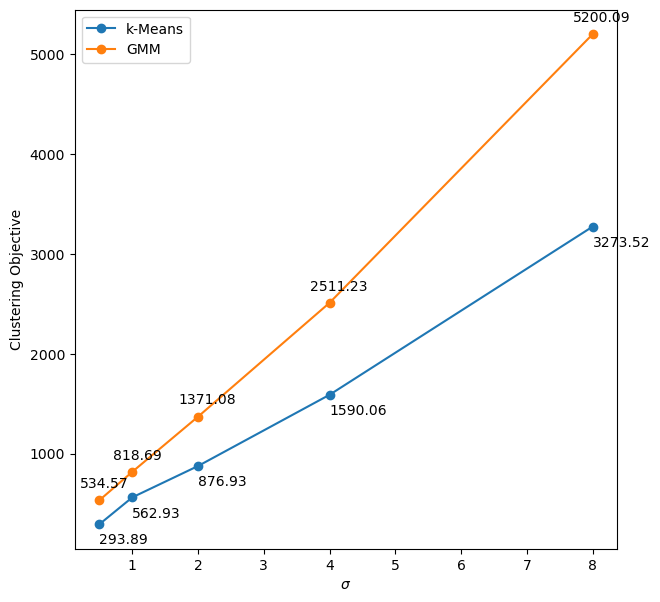

In [284]:
plt.figure(figsize=(7,7))
plt.plot(sigmas, km_objs, label="k-Means", marker='o')
plt.plot(sigmas, gmm_objs, label="GMM", marker='o')
for i in range(len(sigmas)):
    plt.annotate('{0:.2f}'.format(km_objs[i]), xy=(sigmas[i], km_objs[i]-200))
    plt.annotate('{0:.2f}'.format(gmm_objs[i]), xy=(sigmas[i]-0.3, gmm_objs[i]+125))
plt.xlabel("$\sigma$")
plt.ylabel("Clustering Objective")
plt.legend()
plt.savefig("clustering_objective.pdf")

## 2. Linear Dimensionality Reduction

In [451]:
def get_data(filename):
    fo = open(f"data/{filename}", "r")
    lines = fo.readlines()
    data = []
    for line in lines:
        data.append(list(map(float, line.strip().split(','))))
    return np.array(data)

In [452]:
def reduced_buggy_pca(X, d):
    U, S, Vt = np.linalg.svd(X)
    return np.dot(X, Vt.T[:, :d])

In [453]:
def reduced_demeaned_pca(X, d):
    U, S, Vt = np.linalg.svd(X)
    X = X - np.mean(X, axis=0)
    return np.dot(X, Vt.T[:, :d])

In [454]:
def reduced_normalized_pca(X, d):
    U, S, Vt = np.linalg.svd(X)
    sigma = np.std(X, axis=0)
    X = X - np.mean(X, axis=0)
    X = X/sigma
    return np.dot(X, Vt.T[:, :d])

In [455]:
def reduced_dro(X, d):
    U, S, Vt = np.linalg.svd(X)
    A = Vt.T[:, :d]
    b = np.mean(X, axis=0)
    return np.dot(X - b, A)

In [456]:
def reconstruct_buggy_pca(X_new, X, d):
    Vt = np.linalg.svd(X)[2]
    return np.dot(X_new, Vt[:d, :])

In [457]:
def reconstruct_demeaned_pca(X_new, X, d):
    Vt = np.linalg.svd(X)[2]
    X_ =  np.dot(X_new, Vt[:d, :])
    return X_ + np.mean(X, axis=0)

In [458]:
def reconstruct_normalized_pca(X_new, X, d):
    Vt = np.linalg.svd(X)[2]
    X_ =  np.dot(X_new, Vt[:d, :])
    X_ = X_ * np.std(X, axis=0)
    return X_ + np.mean(X, axis=0)

In [459]:
def reconstruct_dro(X_new, X, d):
    U, S, Vt = np.linalg.svd(X)
    A = Vt.T[:, :d]
    b = np.mean(X, axis=0)
    X_ = np.dot(X_new, A.T) + b
    return X_

In [460]:
def reconstruction_error(X, Z):
    return sum(np.linalg.norm(X-Z, axis=1)**2)/len(X)

# 2D dataset

### Buggy PCA

In [483]:
X = get_data("data2D.csv")
Z = reduced_buggy_pca(X, 1)
X_rec = reconstruct_buggy_pca(Z, X, 1)
err_2_buggy = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_2_buggy)

Reconstruction error:  0.8869030837347942


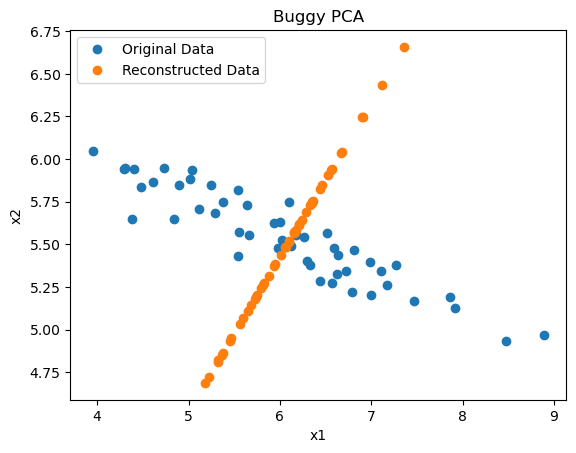

In [484]:
plt.plot(X[:, 0], X[:, 1], 'o', label="Original Data")
plt.plot(X_rec[:, 0], X_rec[:, 1], 'o', label="Reconstructed Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Buggy PCA")
plt.legend()
plt.savefig("buggy_pca.pdf")

### Demeaned Data

In [486]:
X = get_data("data2D.csv")
Z = reduced_demeaned_pca(X, 1)
X_rec = reconstruct_demeaned_pca(Z, X, 1)
err_2_demean = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_2_demean)

Reconstruction error:  0.8812808168689892


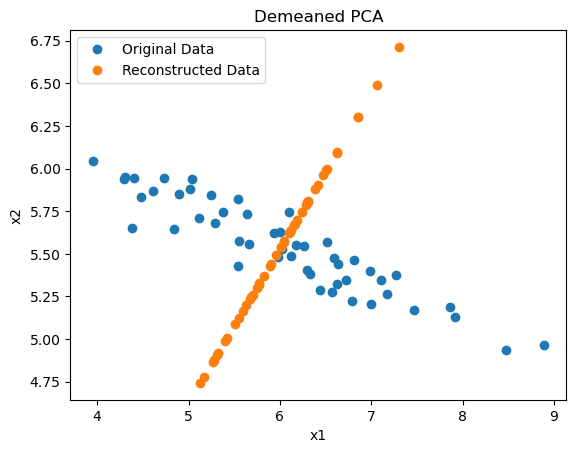

In [487]:
plt.plot(X[:, 0], X[:, 1], 'o', label="Original Data")
plt.plot(X_rec[:, 0], X_rec[:, 1], 'o', label="Reconstructed Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Demeaned PCA")
plt.legend()
plt.savefig("demeaned_pca.pdf")

### Normalized Data

In [488]:
X = get_data("data2D.csv")
Z = reduced_normalized_pca(X, 1)
X_rec = reconstruct_normalized_pca(Z, X, 1)
err_2_normalized = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_2_normalized)

Reconstruction error:  1.1582674004706686


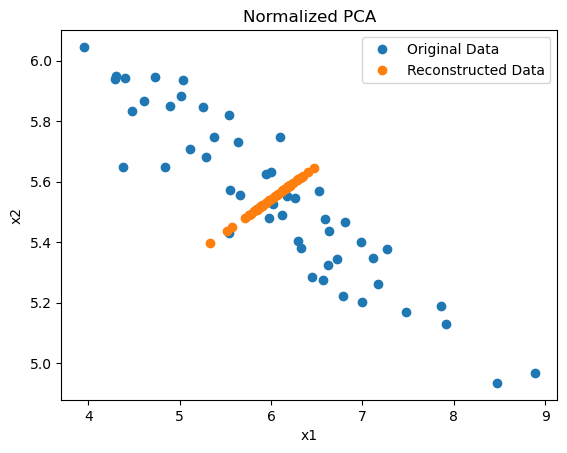

In [489]:
plt.plot(X[:, 0], X[:, 1], 'o', label="Original Data")
plt.plot(X_rec[:, 0], X_rec[:, 1], 'o', label="Reconstructed Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Normalized PCA")
plt.legend()
plt.savefig("normalized_pca.pdf")

### DRO

In [490]:
X = get_data("data2D.csv")
Z = reduced_dro(X, 1)
X_rec = reconstruct_dro(Z, X, 1)
err_2_dro = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_2_dro)

Reconstruction error:  0.8812808168689892


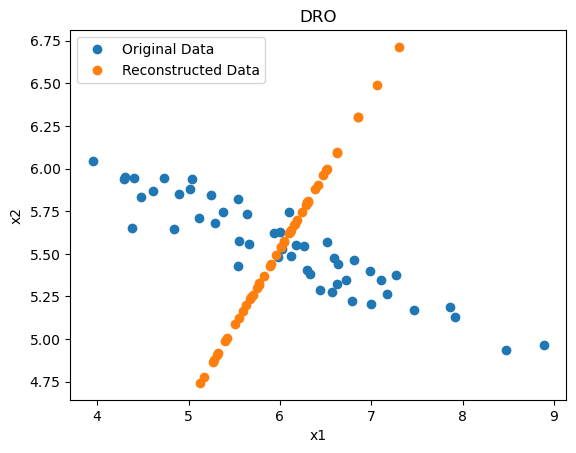

In [491]:
plt.plot(X[:, 0], X[:, 1], 'o', label="Original Data")
plt.plot(X_rec[:, 0], X_rec[:, 1], 'o', label="Reconstructed Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("DRO")
plt.legend()
plt.savefig("dro.pdf")

## 1000D dataset

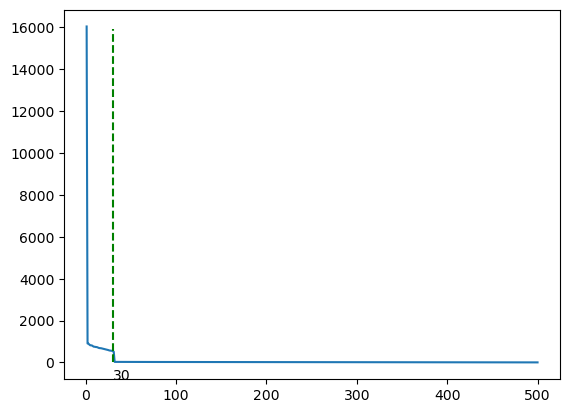

In [542]:
X = get_data("data1000D.csv")
U, S, Vt = np.linalg.svd(X)
plt.plot(np.arange(1, len(S)+1), S)
plt.plot([30 for _ in range(200)], np.arange(1, 16000, 80), '--g')
plt.annotate('30', xy=(30, -800))
plt.savefig('elbow.pdf')

In [543]:
X = get_data("data1000D.csv")
Z = reduced_buggy_pca(X, 30)
X_rec = reconstruct_buggy_pca(Z, X, 30)
err_1000_buggy = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_1000_buggy)

Reconstruction error:  802.7313986203577


In [544]:
X = get_data("data1000D.csv")
Z = reduced_demeaned_pca(X, 30)
X_rec = reconstruct_demeaned_pca(Z, X, 30)
err_1000_demean = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_1000_demean)

Reconstruction error:  802.731343581683


In [545]:
X = get_data("data1000D.csv")
Z = reduced_normalized_pca(X, 30)
X_rec = reconstruct_normalized_pca(Z, X, 30)
err_1000_normalized = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_1000_normalized)

Reconstruction error:  1269.8886717072478


In [546]:
X = get_data("data1000D.csv")
Z = reduced_dro(X, 30)
X_rec = reconstruct_dro(Z, X, 30)
err_1000_dro = reconstruction_error(X, X_rec)
print("Reconstruction error: ", err_1000_dro)

Reconstruction error:  802.731343581683


In [557]:
print("\t\t2D Data\t\t\t 1000D Data")
print("Buggy PCA: \t", err_2_buggy, "\t", err_1000_buggy)
print("Demeaned PCA: \t", err_2_demean, "\t", err_1000_demean)
print("Normalized PCA: ", err_2_normalized, "\t", err_1000_normalized)
print("DRO: \t\t", err_2_dro, "\t", err_1000_dro)

		2D Data			 1000D Data
Buggy PCA: 	 0.8869030837347942 	 802.7313986203577
Demeaned PCA: 	 0.8812808168689892 	 802.731343581683
Normalized PCA:  1.1582674004706686 	 1269.8886717072478
DRO: 		 0.8812808168689892 	 802.731343581683
